In [1]:
import cv2
import imutils
import quality_filter
import sys
import numpy as np
from math import sqrt
from imutils import contours
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def read_threshold(image="Image (3).jpg"):
    """
    This function returns thresholded,eroded,dilated version of original image. By doing so,
    Contours can be find

    Args:
        image (str, optional): Image to make measurements. Defaults to "Image (9).jpg".

    Returns:
        Array: Array of pixels, representing the thresholded image.
    """
    image = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.bilateralFilter(gray, d=17,sigmaSpace=185,sigmaColor=185)
    ret, thresh = cv2.threshold(gray, 29, 255,cv2.THRESH_BINARY) 
    #Threshold filter is not consistent , #TODO #TEST THRESH_OTSU
    edged = cv2.dilate(thresh, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=2)
    return edged


In [3]:
def contours(image):
    """
    Finds contours for given image, #TODO ##MERGE BEFORE DEPLOYMENT

    Args:
        image (array): Array to find contours on

    Returns:
        List: List of arrays where each element represent contour of one object.
    """
    cnts = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts


In [4]:
def finger_tips(cnts):
    """
    As the biggest contour is going to be contour of the hand, contour with biggest area will be the hand's contour
    By finding the convexHull of this contour and Defects of this convex hull, finger tip locations can be calculated.
    #TODO ##Vague
    
    

    Args:
        cnts list: List of arrays, containing contours of the objects in image

    Returns:
        List: List of tuple , where each element represents one finger tip.
    """
    hand = max(cnts,key=cv2.contourArea)
    hull = cv2.convexHull(hand,returnPoints=False)
    defects = cv2.convexityDefects(hand, hull)

    
    M = cv2.moments(hand)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    endlist=[] 
    startlist=[]
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start = tuple(hand[s][0])
        end = tuple(hand[e][0])
        far = tuple(hand[f][0])

        # Cosine Theorem more information at Reference[1]

        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)

        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
        
        if angle <= np.pi / 2:
            #Here if angle is smaller than pi/2 Far = space between fingers
            
            #Right Hand: Start[0] = Thumb (1)
            #            Start[1] = Index (2)
            #            Start[2] = Middle (3)
            #            Start[3] = Ring (4)
            #            End[3]  = Little  (5)

            #Left Hand: Start[0] = Little (5)
            #           Start[1] = Ring (4)
            #           Start[2] = Middle (3)
            #           Start[3] = Index (2)
            #           End[3] = Thumb (1)
            
            startlist.append(start)
            endlist.append(end)
    startlist.append(endlist[3])
    return startlist,[cx,cy],hand

In [5]:
fintips_image=read_threshold("Image (16).jpg")
cont = contours(fintips_image)
fin_tips,center,hand = finger_tips(cont)
fingersimage = cv2.imread("Image (16).jpg")

In [6]:
count = 0
#Finger Tips
for i in fin_tips:
    cv2.circle(fingersimage,tuple(i),24,[255,0,0],-1)
    count += 1
    cv2.putText(fingersimage,str(count),tuple(i),cv2.FONT_HERSHEY_SIMPLEX,2,(255, 255, 255),2,cv2.LINE_AA)

#Centroid
cv2.circle(fingersimage,tuple(center),24,[0,0,255],-1)
#Highest point in hand contour (As image is in reverse it corresponds to wrist)
extTop = tuple(hand[hand[:, :, 1].argmin()][0])
#Define bottom point as X coordinate of center, Y coordinate of lowest point
bottom = [center[0],extTop[1]]


In [7]:
cv2.circle(fingersimage,tuple(bottom),24,[0,0,255],-1)
cv2.line(fingersimage, tuple(bottom), fin_tips[2], (0, 255, 0), 5)
cv2.rectangle(fingersimage,(fin_tips[0]),(fin_tips[2]),(0,0,255),5)
cv2.rectangle(fingersimage,(fin_tips[4]),(fin_tips[2]),(255,0,0),5)

five_to_three_one = (fin_tips[4])
five_to_three_two = (fin_tips[4][0],fin_tips[2][1])
cv2.circle(fingersimage,tuple(five_to_three_two),24,[0,0,255],-1)


one_to_three_two = (fin_tips[0][0],fin_tips[2][1])

cv2.circle(fingersimage,tuple(one_to_three_two),24,[0,0,255],-1)


from scipy.spatial import distance as dist

cv2.line(fingersimage, (five_to_three_two), (five_to_three_one),(255, 255, 255), 4)



dA = dist.euclidean((five_to_three_two), (five_to_three_one))

# print(dA)

# plt.figure(figsize=(10,10)) 
# plt.imshow(cv2.cvtColor(fingersimage, cv2.COLOR_BGR2RGB))

11.13


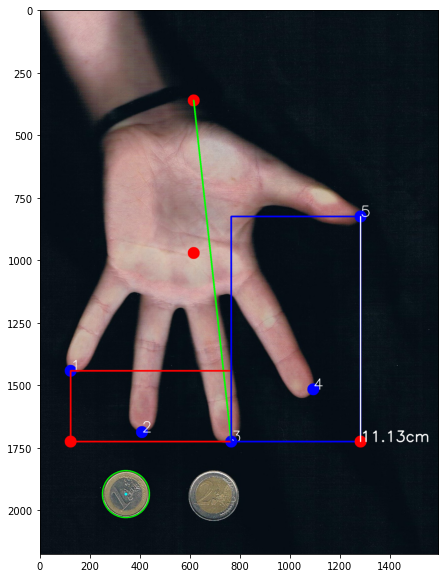

In [8]:
cntsSorted=sorted(cont, key=lambda x: cv2.contourArea(x))
(x,y), r = cv2.minEnclosingCircle(cntsSorted[0])

center = (int(x),int(y))
radius = int(r)
diameter = radius * 2
cv2.circle(fingersimage,center,radius,(0,255,0),3)
cv2.circle(fingersimage,center,3,(255,255,0),3)

#Diameter of 1 Euro Coin :  23.25mm
#Diameter of 2 Euro Coin :  25.75mm

ppM = diameter / 2.32500

dimA=dA/ppM

print(round(dimA,2))
txt = str(round(dimA,2)) + "cm"
cv2.putText(fingersimage,txt,tuple(five_to_three_two),cv2.FONT_HERSHEY_SIMPLEX,2,(255, 255, 255),4,cv2.LINE_AA)

plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(fingersimage, cv2.COLOR_BGR2RGB))

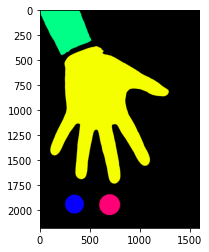

In [9]:
#Segmentation Test

labels = cv2.connectedComponentsWithStats(fintips_image,4,cv2.CV_32S)
#[0] = Number of labels
#[1] = label matrix
#[2] = stat matrix (STAT_LEFT,STAT_TOP,STAT_WIDTH,STAT_HEIGHT,STAT_AREA)
#[3] = centroid matrix

label_hue = np.uint8(179 * labels[1] / np.max(labels[1]))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0

plt.imshow(labeled_img)

In [10]:
"""
Resources List:
https://pierfrancesco-soffritti.medium.com/handy-hands-detection-with-opencv-ac6e9fb3cec1
https://medium.com/analytics-vidhya/hand-detection-and-finger-counting-using-opencv-python-5b594704eb08
https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/
https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python
"""

'\nResources List:\nhttps://pierfrancesco-soffritti.medium.com/handy-hands-detection-with-opencv-ac6e9fb3cec1\nhttps://medium.com/analytics-vidhya/hand-detection-and-finger-counting-using-opencv-python-5b594704eb08\nhttps://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/\nhttps://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/\nhttps://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python\n'